# I. Probability

From the continuous stream of data, extract the periods of interest to train a classifier aiming to predict an incoming movement from the user.
These periods of interest will be used to extract features and then to calculate the probability of predecting an incoming movement on a specific period of interest (around the movement onset).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill
import math
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

## 1. Parameters and functions definition

### Parameters

Define in the parameters the start and the end of the each period of interest. The start and end are defined with respect to the event chosen later on (movement onset or other).

- Idle for each modality which will be class 0
- Incoming period for all modality which will be class 1
- Period on which we want to calculate the probability of prediction

In [2]:
fs         = 250
path       = 'C:/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/'
parameters = {'idle_eeg_start'  : -6, 'idle_eeg_end'  : -5, 
              'idle_emg_start'  : -2, 'idle_emg_end'  : -1,
              'idle_gaze_start' : -2, 'idle_gaze_end' : -1,
              'intent_start'    : -1, 'intent_end'    :  0, 
              'interest_start'  : -2, 'interest_end'  :  1}
train_size = 100

### Functions leading to probability calculation

<font size="3" color='orange'>    <b>Read/load data</b>
    
Data are just pre-processed. EMG, EEG and Eye-tracking are under the form of a continuous stream recorded all along the experiment. Additionally we have specific event that we'll use to extract then to process the data during each trial rather than processing the whole continuous streams.

In [3]:
def read_and_save(ID):
    
    '''
    Just once, read and load the data. Then, use the created .npy files.
    '''
    
    ID             = str(ID)
    
    movement_onset = pd.read_csv( path + ID + '/\motion_onset_event_latencies.csv', header = None)
    movement_onset = movement_onset.values[0]
    
    idle_onset     = pd.read_csv( path + ID + '/\idle_event_latencies.csv', header = None)
    idle_onset     = idle_onset.values[0]

    
    eeg_all        = pd.read_csv(path + ID + '/\eeg.csv', header = None)
    best_chan      = pd.read_csv(path + ID + '/\chans_rp-win_-1-0.csv', header=None)
    eeg = []
    for i in best_chan.iloc[1:,0].astype(int)-1:  
        eeg.append(eeg_all.iloc[i,:])
    eeg = np.asarray(eeg)
    
    noisy_idle     = pd.read_csv(path + ID + '/\noisy_epochs_idle_rp-win_-1-0.csv', header = None)
    noisy_intent   = pd.read_csv(path + ID + '/\noisy_epochs_rp_rp-win_-1-0.csv', header = None)
        
    emg            = pd.read_csv(path + ID + '/\emg.csv', header = None)
    emg.iloc[1,:]  = emg.iloc[1,:] - np.mean(emg.iloc[1, :])
    emg.iloc[0,:]  = emg.iloc[0,:] - np.mean(emg.iloc[0, :])
        
    velocity       = pd.read_csv(path + ID + '/\motion.csv', header = None)
    
    gaze           = pd.read_csv(path + ID + '/\gaze.csv', header = None)
    
    np.save(path + ID + '/NPYmovement', movement_onset)
    np.save(path + ID + '/NPYidle', idle_onset)
    np.save(path + ID + '/NPYeeg', eeg)
    np.save(path + ID + '/NPYemg', emg)
    np.save(path + ID + '/NPYvelocity', velocity)
    np.save(path + ID + '/NPYgaze', gaze)

In [4]:
def load(ID):
    
    '''
    Load the .npy files and load the noisy idle [?s; ?s] and noisy intent [-1s; 0s].
    Create a data dictionnary.
    '''
    
    ID        = str(ID)
    
    movement_onset = np.load(path + ID + '//NPYmovement.npy')
    idle_onset     = np.load(path + ID + '/NPYidle.npy')
    eeg            = np.load(path + ID + '//NPYeeg.npy')
    emg            = np.load(path + ID + '//NPYemg.npy')
    velocity       = np.load(path + ID + '//NPYvelocity.npy')
    gaze           = np.load(path + ID + '//NPYgaze.npy')
    
    noisy_idle     = pd.read_csv(path + ID + '/noisy_epochs_idle_rp-win_-1-0.csv', header = None)
    noisy_intent   = pd.read_csv(path + ID + '/noisy_epochs_rp_rp-win_-1-0.csv', header = None)
    
    data = {'movement_onset' : movement_onset, 'idle_onset' : idle_onset,
            'eeg' : eeg, 'emg' : emg, 'velocity' : velocity, 'gaze' : gaze,
            'noisy_idle' : noisy_idle, 'noisy_intent' : noisy_intent}
    
    return data

<font size="3" color='orange'>    <b>Period of interest</b>
    
We're defining here on function that extracts the desired period of time on a continuous stream of data. The following function is applying this process to extract the class 0 and 1 of our future classifier as well as the period on which we'll want to test this classifier.

In [5]:
def area_of_interest(signal, events, start, end):
    
    '''
    Exctract the period of data interesting us on the continuous stream of data.
    '''
    
    samples_before = fs *   start
    samples_after  = fs *   end
    area           = np.zeros((len(events), -(samples_before - samples_after), signal.shape[0]))
    
    for k in range(len(events)):
        
        for j in range(signal.shape[0]):
            
            area[k, 0:-(samples_before-samples_after), j] = signal[j, events[k] + samples_before : 
                                                                      events[k] + samples_after]
            
    return area

In [6]:
def areas(data):
    
    '''
    Use the function defined above to extract the idle, the intent and the interest of each modality.
    '''
    
    areas                      = {'idle_eeg': [], 'idle_emg': [], 'idle_gaze': [],
                                  'intent_eeg': [], 'intent_emg': [], 'intent_gaze': [],
                                  'interest_eeg': [], 'interest_emg': [], 'interest_gaze': [], 'interest_velocity': []}
    
    areas['idle_eeg']          = area_of_interest(data['eeg'],  data['movement_onset'], 
                                              parameters['idle_eeg_start'], parameters['idle_eeg_end'])
    areas['idle_emg']          = area_of_interest(data['emg'],  data['movement_onset'],
                                              parameters['idle_emg_start'], parameters['idle_emg_end'])
    areas['idle_gaze']         = area_of_interest(data['gaze'], data['movement_onset'],
                                              parameters['idle_gaze_start'], parameters['idle_gaze_end'])
    
    areas['intent_eeg']        = area_of_interest(data['eeg'],  data['movement_onset'], 
                                              parameters['intent_start'], parameters['intent_end'])
    areas['intent_emg']        = area_of_interest(data['emg'],  data['movement_onset'], 
                                              parameters['intent_start'], parameters['intent_end'])
    areas['intent_gaze']       = area_of_interest(data['gaze'], data['movement_onset'], 
                                              parameters['intent_start'], parameters['intent_end'])
    
    areas['interest_eeg']      = area_of_interest(data['eeg'],  data['movement_onset'], 
                                              parameters['interest_start']-1, parameters['interest_end'])
    areas['interest_emg']      = area_of_interest(data['emg'],  data['movement_onset'], 
                                              parameters['interest_start']-1, parameters['interest_end'])
    areas['interest_gaze']     = area_of_interest(data['gaze'], data['movement_onset'], 
                                              parameters['interest_start']-1, parameters['interest_end'])
    areas['interest_velocity'] = area_of_interest(data['velocity'], data['movement_onset'], 
                                              parameters['interest_start'], parameters['interest_end'])
    
    return areas

<font size="3" color='orange'>    <b>Feature extraction</b>
    
We define below time-domain features for the EMG data. The EEG data will be processed calculating the window means and the gaze velocity will be computed for the eye-tracking data.

In [7]:
'''
Define the functions for the features extraction on the EMG data.
'''

def rms(values):
    return np.sqrt(sum(values**2)/len(values))

def mini(values):
    return np.min(values)

def maxi(values):
    return np.max(values)

def mav(values):
    return np.mean(abs(values))

def var(values):
    return np.var(values)

# diff() waveform

feat_list = [rms, mini, maxi, mav, var]

In [8]:
def emg_feature_extraction(area):
    
    '''
    Apply the feature extraction functions on the areas of interest.
    Features are extracted once per second (1s = 250 samples) so once per idle and intent period.
    On the interest period, the features are extracted once, then the 250 samples window is slided by 1 sample and the extraction strats again.
    '''
    
    sld_size = 1
    
    if area.shape[1] == 250 or area.shape[1] == 50:                           # For idle, intent period and accuracy over time.
        features = np.zeros((area.shape[0], area.shape[2] * len(feat_list)))
        for k in range(area.shape[0]):
            for j in range(area.shape[2]):
                for i in range(len(feat_list)):
                    
                    features[k, i + (len(feat_list)*j)] = np.apply_along_axis(feat_list[i], 0, area[k, :, j])
    
    else:
        features = np.zeros((area.shape[0], area.shape[2] * len(feat_list), (area.shape[1]//sld_size) - fs + sld_size))                  
        for l in range(features.shape[2]):
            for k in range(area.shape[0]):
                for j in range(area.shape[2]):
                    for i in range(len(feat_list)):
                            
                        features[k, i + (len(feat_list)*j), l] = np.apply_along_axis(feat_list[i], 0, 
                                                                 area[k, (sld_size*l):fs+(sld_size*l), j])
    
    return features

Before the feature extraction, we remove the EEG idle and preparation period which were marked as too noisy during the pre-processing.

In [9]:
def eeg_filtering(data, area):
    
    '''
    Use the noisy idle [?s; ?s] and noisy intent [-1s; 0s] to remove them from the extracted trials.
    '''
   
    area['idle_eeg']   = np.delete(area['idle_eeg'], data['noisy_idle'].values[1:].astype(int)-1, axis=0)
    area['intent_eeg'] = np.delete(area['intent_eeg'], data['noisy_intent'].values[1:].astype(int)-1, axis=0)
        
    return area['idle_eeg'], area['intent_eeg']

In [10]:
def eeg_feature_extraction(area):
    
    '''
    Extract the mean on the eeg data as a feature.
    The mean is extracted 10 times per window per channel.
    Extract per second then slide the window per 1 sample for the area of interest.
    '''
    
    sld_size  = 1
    feat_size = 25
    
    if area.shape[1] == 250:                # For idle and intent period.
        features = np.zeros((area.shape[0], (fs//feat_size) * area.shape[2]))
        for k in range(area.shape[0]):
            for j in range(area.shape[2]):
                for i in range(fs//feat_size):
                    
                    features[k, i+(fs//feat_size) * j] = np.mean(area[k, (feat_size*i) : (feat_size)+(feat_size)*i, j])
                    
    elif area.shape[1] == 50:               # For accuracy over time.
        features = np.zeros((area.shape[0], (50//feat_size) * area.shape[2]))
        for k in range(area.shape[0]):
            for j in range(area.shape[2]):
                for i in range(50//feat_size):
                    
                    features[k, i+(50//feat_size) * j] = np.mean(area[k, (feat_size*i) : (feat_size)+(feat_size)*i, j])
                    
    else:
        features = np.zeros((area.shape[0], (fs//feat_size) * area.shape[2], (area.shape[1]//sld_size) - fs + sld_size))
        for k in range(area.shape[0]):
            for l in range(features.shape[2]):
                for j in range(area.shape[2]):
                    for i in range(fs//feat_size):
                        
                        features[k, i+(fs//feat_size) * j, l] = np.mean(area[k, (feat_size*i)+(sld_size*l): \
                                                                               (feat_size)+(feat_size)*i+(sld_size*l), j])
    return features                    

The EEG signal slowly shifts along the experiment, thus we proceed to a baseline correction to standardize the features between the early and late trials.

In [11]:
def baseline_correction(area, features):
    
    '''
    Substract to every window of 250 samples the value of the first of these 250.
    1 correction for the idle/preparation period and more for the period of interest since it's longer than 1s.
    '''
    
    features_cor = np.zeros((features.shape))
    
    for k in range(features.shape[0]):
        
        if features_cor.ndim == 2 and features.shape[1] == 200:
        
            for j in range(area.shape[2]):
            
                features_cor[k, (10*j):10+(10*j)] = features[k, (10*j):10+(10*j)] - area[k, 0, j]
                
        elif features_cor.ndim == 2 and features.shape[1] == 40:
        
            for j in range(area.shape[2]):
            
                features_cor[k, (2*j):2+(2*j)] = features[k, (2*j):2+(2*j)] - area[k, 0, j]
        
        else:
            
            for j in range(area.shape[2]):
                for i in range(features.shape[2]):
            
                    features_cor[k, (10*j):10+(10*j), i] = features[k, (10*j):10+(10*j), i] - area[k, i, j]
            
    return features_cor

In [ ]:
def eye_feature_extraction(area):
    
    '''
    Calculate the velocity of the gaze from the 3D coordinates.
    '''
    
    sld_size  = 1
    
    if area.shape[1] == 250:
        features = np.zeros((area.shape[0], fs-1 * area.shape[2]))
        for k in range(area.shape[0]):
            for i in range(fs-1):
                    
                features[k, i+(fs//feat_size) * j] = math.sqrt(np.diff(area[k, ])^2 + np.diff(area[k, ])^2 +np.diff(area[k, ])^2)
                    
    else:
        features = np.zeros((area.shape[0], fs-1 * area.shape[2], (area.shape[1]//sld_size) - fs + sld_size))
        for k in range(area.shape[0]):
            for l in range(features.shape[2]):
                for i in range(fs-1):
                        
                    features[k, , l] = 
    return features   

<font size="3" color='orange'>    <b>Classification</b>

Use the features to train a LDA classifier to predict in there is a movement preparation or not.

In [12]:
def classification(ID, features_idle, features_intention):
    
    '''
    The features are splited if we want to only use a part of them and the other part to calculate the probability.
    The function return the accuracy and the standart deviation output from a 10 fold cross-validation.
    Classification parameters are saved in order to use them to compute the classification metrics in another script.
    '''
    
    features_idle      = features_idle[:(len(features_idle)*train_size)//100, :]
    features_intention = features_intention[:(len(features_intention)*train_size)//100, :]
    
    class_0 = pd.concat([pd.DataFrame(features_idle), pd.DataFrame(np.zeros((len(features_idle))))], 
                        axis=1, keys={'features', 'class'})
    class_1 = pd.concat([pd.DataFrame(features_intention), pd.DataFrame(np.ones((len(features_intention))))], 
                        axis=1, keys={'features', 'class'})
    
    X       = pd.concat([class_0.iloc[:,:-1], class_1.iloc[:,:-1]], axis=0)
    y       = pd.concat([class_0.iloc[:,-1], class_1.iloc[:,-1]], axis=0)
    
    clf     = LDA(solver='lsqr', shrinkage='auto')
    clf.fit(X, y)
    
    kfolds  = KFold(n_splits=10, random_state=1, shuffle=True)
    
    pred_y  = cross_val_predict(clf, X, y, cv=kfolds)
    
    results = cross_val_score(clf, X, y, cv=kfolds)
    score   = np.mean(results)
    std     = np.std(results)
    
    ID      = str(ID)
    
    if features_idle.shape[1] == 200:
        np.save(path + ID + '/Xeeg', X)
        np.save(path + ID + '/yeeg', y)
        pickle.dump(clf, open(path + ID + '/Clfeeg', 'wb'))
        np.save(path + ID + '/pred_yeeg', pred_y)
        
    elif features_idle.shape[1] > 200:
        np.save(path + ID + '/Xeeg_emg', X)
        np.save(path + ID + '/yeeg_emg', y)
        pickle.dump(clf, open(path + ID + '/Clfeeg_emg', 'wb'))
        np.save(path + ID + '/pred_yeeg_emg', pred_y)
        
    else:
        np.save(path + ID + '/Xemg', X)
        np.save(path + ID + '/yemg', y)
        pickle.dump(clf, open(path + ID + '/Clfemg', 'wb'))
        np.save(path + ID + '/pred_yemg', pred_y)
    
    resume = {'Clf' : clf,  'Score' : score, 'Std' : std}
    print('Accuracy is ' + str(score))
    print('Standard deviation is ' + str(std))
    
    return resume

<font size="3" color='orange'>    <b>Probability testing</b>

Use the trained classifier and test its probability of predicting a movement preparation on the extracted area of interest.

In [13]:
def probability(clf, features_interest):
    
    '''
    Output 1 probability at each set of features of the area of interest.
    Thus, 1 probability every 250 samples and then a slide of 1 sample.
    '''
    
    features_interest = features_interest[-(len(features_interest)*(100-train_size))//100:, :]
    
    proba = np.zeros((features_interest.shape[0], features_interest.shape[2]))

    for k in range(features_interest.shape[0]):
    
        for l in range(features_interest.shape[2]):
        
            proba[k, l] = clf.predict_proba(features_interest[-k, :, l].reshape(1, -1))[0][1]
            
    return proba

<font size="3" color='orange'>    <b>DataFrame and plots</b>

In [14]:
def DF(ID, probability, velocity):
    
    '''
    Create a time axis along with the probability calculation and the velocity of the hand along the trials
    '''
    
    velocity = velocity[-(len(velocity)*(100-train_size))//100:]
    
    time  = np.arange(parameters['interest_start'], parameters['interest_end'], 1/fs)
    time  = np.tile(time, len(probability))

    proba = np.reshape(probability[:, :-1], len(time))

    velo  = np.reshape(velocity, len(time))
    
    idt   = [f'{ID}'] * len(velo)

    data      = np.zeros((len(time), 3))
    data[:,0] = time
    data[:,1] = velo * 1000
    data[:,2] = proba
    final_df       = pd.DataFrame(data, columns=['Time', 'Velocity', 'Probability'])
    final_df['ID'] = idt
    
    return final_df

In [15]:
def plot_proba_EMG(DataFrame):
    
    figure(figsize=(12, 6))

    sns.set_theme(context='talk', style='ticks')
    ep_move = sns.lineplot(data=DataFrame, x='Time', y='Velocity', color='k', legend=False)

    ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

    plt.axvline(0, color='black', label = 'onset', linestyle ='--')

    ax2 = plt.twinx()
    ax2.set_ylabel('Probability', color='b')
    ax2.spines['right'].set_color('b')
    ax2.tick_params(axis='y', colors='b')
    ep_prob = sns.lineplot(data=DataFrame, x='Time', y='Probability', ax=ax2, color='b', legend=False)
    plt.ylim((0,1))
    plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

    ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="b", label='EMG classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

In [16]:
def plot_proba_EEG(DataFrame):
    
    figure(figsize=(12, 6))

    sns.set_theme(context='talk', style='ticks')
    ep_move = sns.lineplot(data=DataFrame, x='Time', y='Velocity', color='k', legend=False)

    ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

    plt.axvline(0, color='black', label = 'onset', linestyle ='--')

    ax2 = plt.twinx()
    ax2.set_ylabel('Probability', color='r')
    ax2.spines['right'].set_color('r')
    ax2.tick_params(axis='y', colors='r')
    ep_prob = sns.lineplot(data=DataFrame, x='Time', y='Probability', ax=ax2, color='r', legend=False)
    plt.ylim((0,1))
    plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

    ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='EEG classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

In [17]:
def plot_proba_EYE(DataFrame):
    
    figure(figsize=(12, 6))

    sns.set_theme(context='talk', style='ticks')
    ep_move = sns.lineplot(data=DataFrame, x='Time', y='Velocity', color='k', legend=False)

    ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

    plt.axvline(0, color='black', label = 'onset', linestyle ='--')

    ax2 = plt.twinx()
    ax2.set_ylabel('Probability', color='g')
    ax2.spines['right'].set_color('g')
    ax2.tick_params(axis='y', colors='g')
    ep_prob = sns.lineplot(data=DataFrame, x='Time', y='Probability', ax=ax2, color='g', legend=False)
    plt.ylim((0,1))
    plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

    ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="g", label='EYE classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

In [18]:
def plot_proba_EEG_EMG(DataFrame):
    
    figure(figsize=(12, 6))

    sns.set_theme(context='talk', style='ticks')
    ep_move = sns.lineplot(data=DataFrame, x='Time', y='Velocity', color='k', legend=False)

    ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

    plt.axvline(0, color='black', label = 'onset', linestyle ='--')

    ax2 = plt.twinx()
    ax2.set_ylabel('Probability', color='m')
    ax2.spines['right'].set_color('m')
    ax2.tick_params(axis='y', colors='m')
    ep_prob = sns.lineplot(data=DataFrame, x='Time', y='Probability', ax=ax2, color='m', legend=False)
    plt.ylim((0,1))
    plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

    ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="m", label='EEG - EMG classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

<font size="3" color='orange'>    <b>Function merge for final probability calculation</b>

In [19]:
def ProcessEMG(ID):
    
    data          = load(ID)
    area          = areas(data)
    idle_feat     = emg_feature_extraction(area['idle_emg'])
    intent_feat   = emg_feature_extraction(area['intent_emg'])
    interest_feat = emg_feature_extraction(area['interest_emg'])
    classifier    = classification(ID, idle_feat, intent_feat)
    proba         = probability(classifier['Clf'], interest_feat)
    DataFrame     = DF(ID, proba, area['interest_velocity'])
    plot_proba_EMG(DataFrame)
    
    return DataFrame

In [20]:
def ProcessEEG(ID):
    
    data              = load(ID)
    area              = areas(data)
    filter_eeg        = eeg_filtering(data, area)
    idle_feat         = eeg_feature_extraction(area['idle_eeg'])
    intent_feat       = eeg_feature_extraction(area['intent_eeg'])
    interest_feat     = eeg_feature_extraction(area['interest_eeg'])
    idle_feat_cor     = baseline_correction(area['idle_eeg'], idle_feat)
    intent_feat_cor   = baseline_correction(area['intent_eeg'], intent_feat)
    interest_feat_cor = baseline_correction(area['interest_eeg'], interest_feat)
    classifier        = classification(ID, idle_feat_cor, intent_feat_cor)
    proba             = probability(classifier['Clf'], interest_feat_cor)
    DataFrame         = DF(ID, proba, area['interest_velocity'])
    plot_proba_EEG(DataFrame)
    
    return DataFrame

In [21]:
def ProcessEEG_EMG(ID):
    
    data                  = load(ID)
    area                  = areas(data)
    
    idle_eeg_feat         = eeg_feature_extraction(area['idle_eeg'])
    intent_eeg_feat       = eeg_feature_extraction(area['intent_eeg'])
    interest_eeg_feat     = eeg_feature_extraction(area['interest_eeg'])
    idle_eeg_feat_cor     = baseline_correction(area['idle_eeg'], idle_eeg_feat)
    intent_eeg_feat_cor   = baseline_correction(area['intent_eeg'], intent_eeg_feat)
    interest_eeg_feat_cor = baseline_correction(area['interest_eeg'], interest_eeg_feat)
    
    idle_emg_feat         = emg_feature_extraction(area['idle_emg'])
    intent_emg_feat       = emg_feature_extraction(area['intent_emg'])
    interest_emg_feat     = emg_feature_extraction(area['interest_emg'])
    
    idle_feat             = np.concatenate((idle_emg_feat, idle_eeg_feat_cor), axis=1)
    intent_feat           = np.concatenate((intent_emg_feat, intent_eeg_feat_cor), axis=1)
    interest_feat         = np.concatenate((interest_emg_feat, interest_eeg_feat_cor), axis=1)
    
    classifier            = classification(ID, idle_feat, intent_feat)
    proba                 = probability(classifier['Clf'], interest_feat)
    DataFrame             = DF(ID, proba, area['interest_velocity'])
    plot_proba_EEG_EMG(DataFrame)

    return DataFrame

In [ ]:
def ProcessEye(ID):
    
    data          = load(ID)
    area          = areas(data)
    idle_feat     = eye_feature_extraction(area['idle_emg'])
    intent_feat   = eye_feature_extraction(area['intent_emg'])
    interest_feat = eye_feature_extraction(area['interest_emg'])
    classifier    = classification(ID, idle_feat, intent_feat)
    proba         = probability(classifier['Clf'], interest_feat)
    DataFrame     = DF(ID, proba, area['interest_velocity'])
    plot_proba_EYE(DataFrame)
    
    return DataFrame

## 2. Application

### Plot options

- One plot per modality per participant
- All the probabilities per modalities on one plot
- Average all the data for 1 curve per modality
- Average the average per participant + plot the individual curves but shaded.

Accuracy is 0.8400000000000001
Standard deviation is 0.08537498983243798


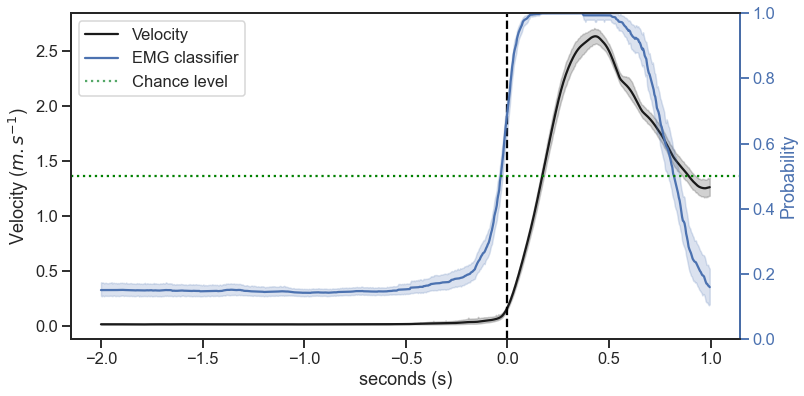

In [22]:
EMG_1 = ProcessEMG(11)

Accuracy is 0.6603333333333332
Standard deviation is 0.09097862996941157


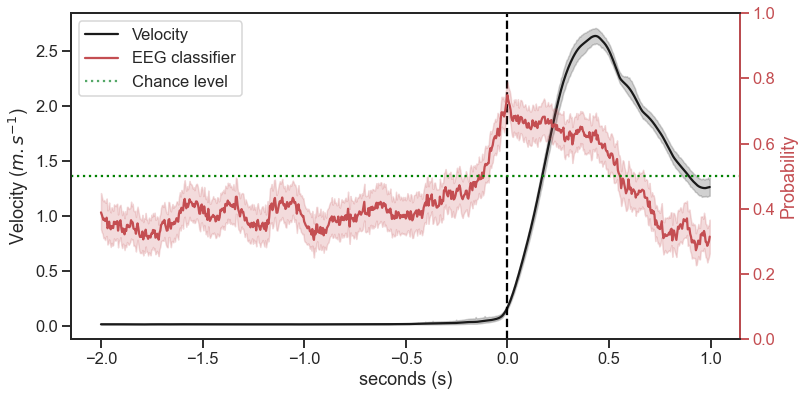

In [23]:
EEG_1 = ProcessEEG(11)

Accuracy is 0.8333333333333334
Standard deviation is 0.053748384988657014


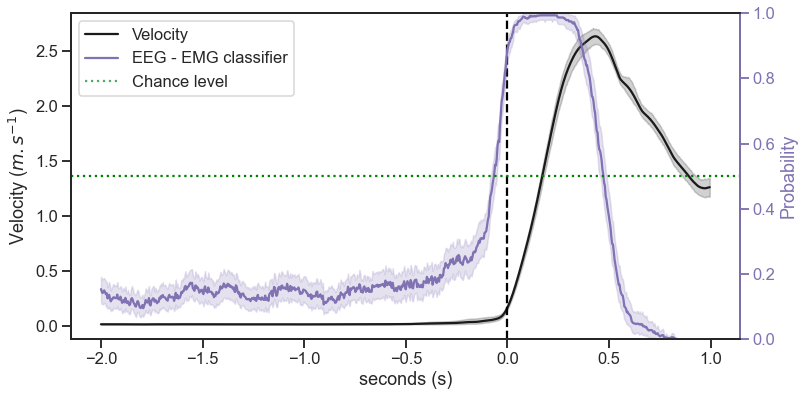

In [24]:
EEG_EMG_1 = ProcessEEG_EMG(11)

Accuracy is 0.763888888888889
Standard deviation is 0.08539125638299663


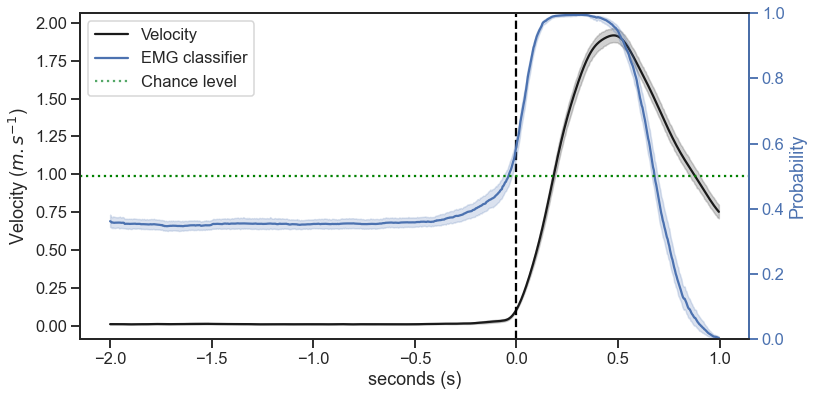

In [25]:
EMG_3 = ProcessEMG(3)

Accuracy is 0.6280645161290324
Standard deviation is 0.08478472463679866


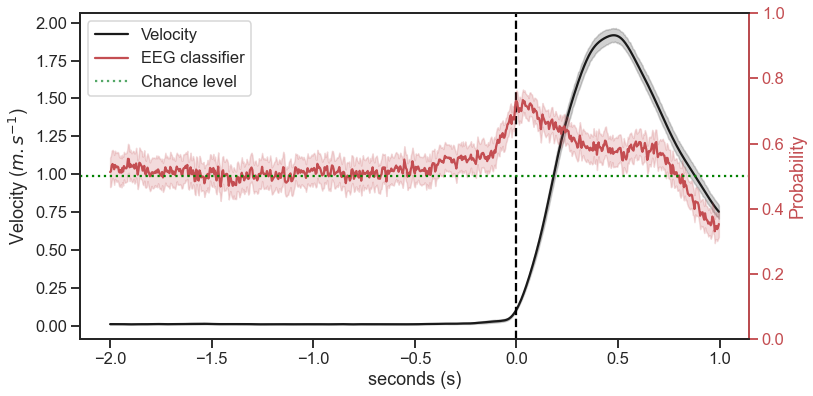

In [26]:
EEG_3 = ProcessEEG(3)

Accuracy is 0.7166666666666667
Standard deviation is 0.060603956192420635


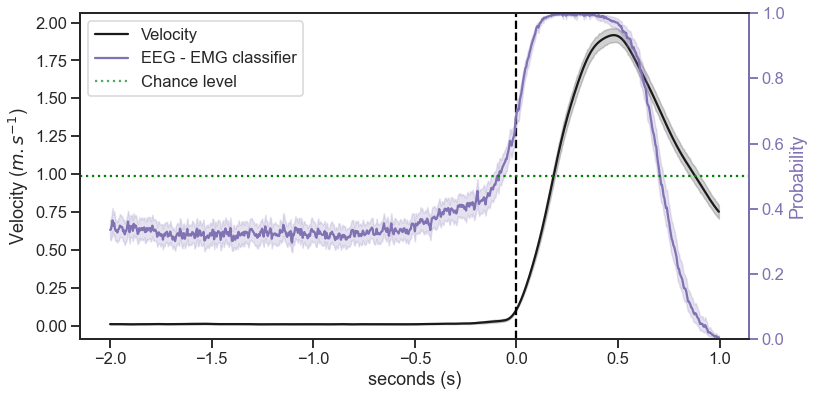

In [27]:
EEG_EMG_3 = ProcessEEG_EMG(3)

Accuracy is 0.631031746031746
Standard deviation is 0.07456555113437971


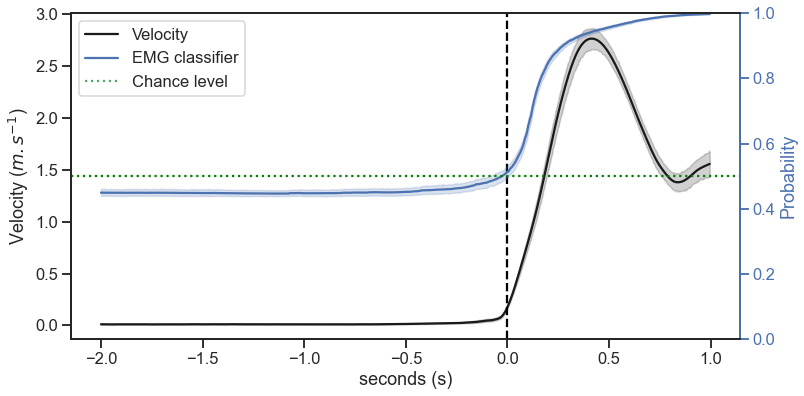

In [28]:
EMG_4 = ProcessEMG(4)

Accuracy is 0.649080459770115
Standard deviation is 0.11272815270232728


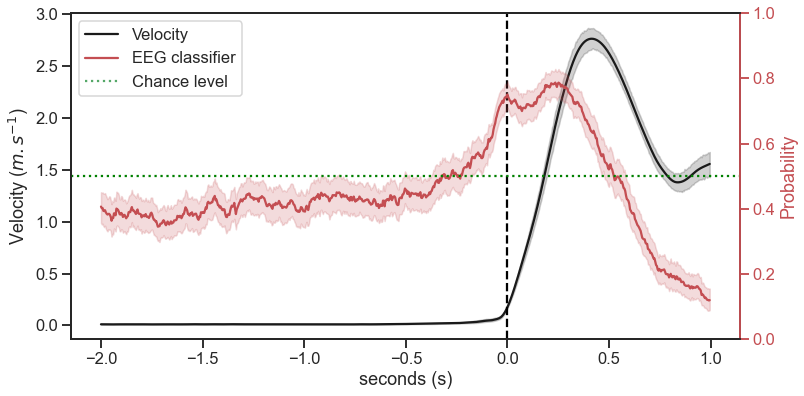

In [29]:
EEG_4 = ProcessEEG(4)

Accuracy is 0.692936507936508
Standard deviation is 0.0454318462986073


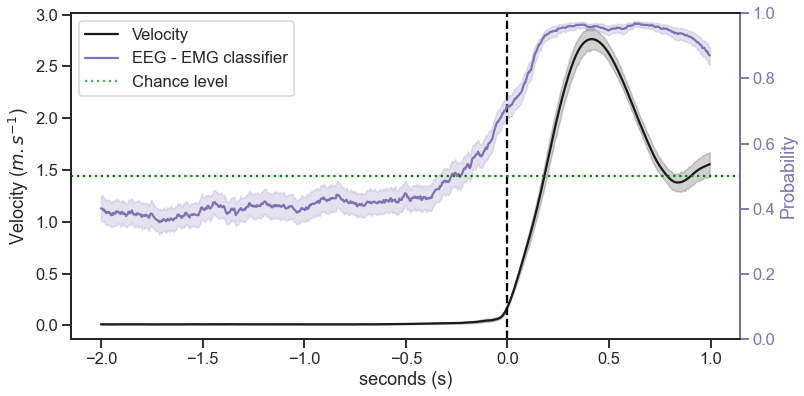

In [30]:
EEG_EMG_4 = ProcessEEG_EMG(4)

Accuracy is 0.7392045454545455
Standard deviation is 0.047789987055010696


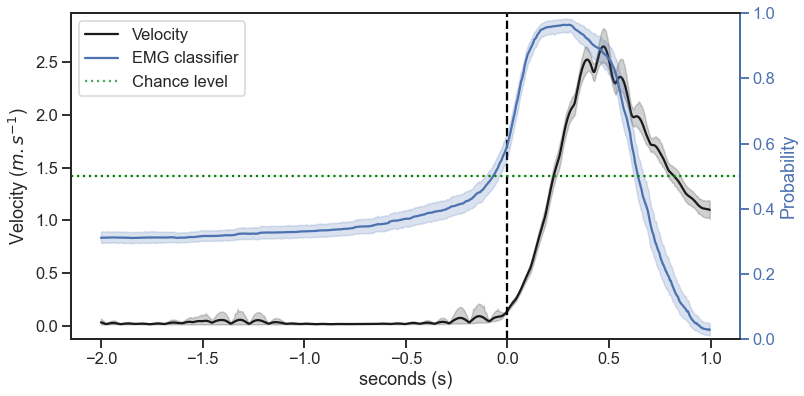

In [31]:
EMG_5 = ProcessEMG(5)

Accuracy is 0.6988095238095238
Standard deviation is 0.06071428571428572


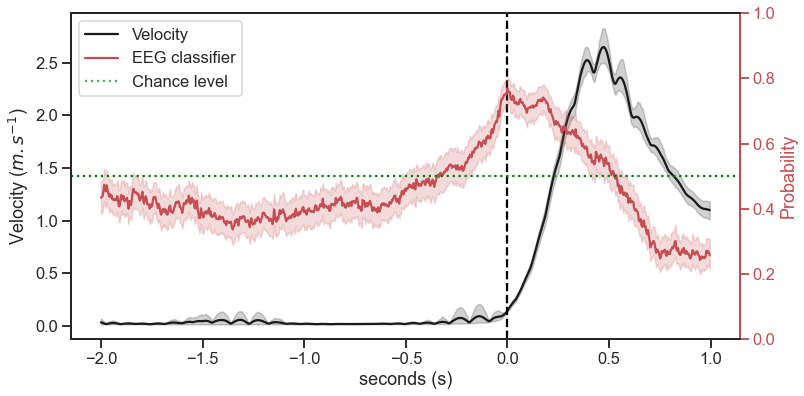

In [32]:
EEG_5 = ProcessEEG(5)

Accuracy is 0.7454545454545455
Standard deviation is 0.058234863760538214


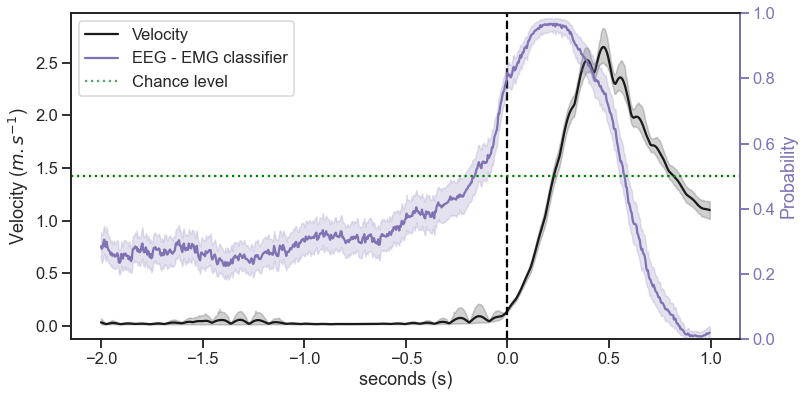

In [33]:
EEG_EMG_5 = ProcessEEG_EMG(5)

Accuracy is 0.8447415329768271
Standard deviation is 0.05140030002522245


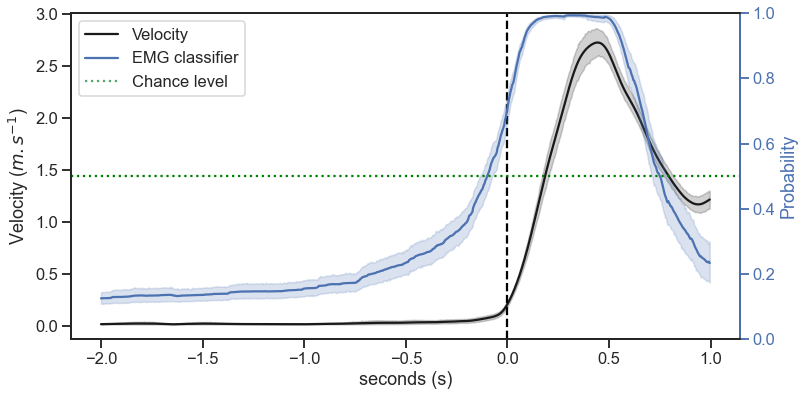

In [34]:
EMG_6 = ProcessEMG(6)

Accuracy is 0.5953201970443349
Standard deviation is 0.08897764075183455


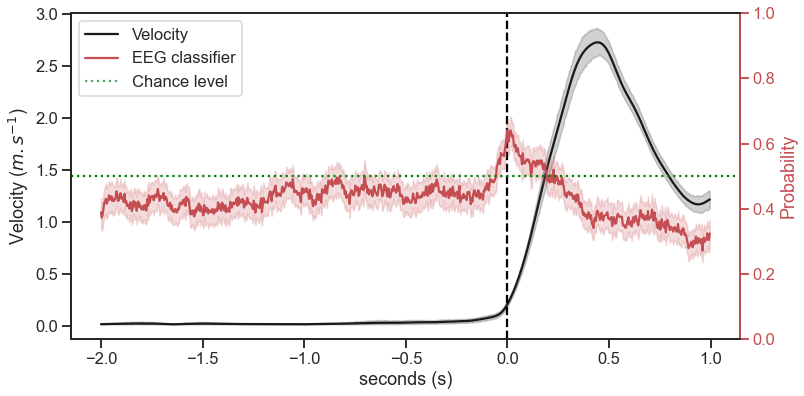

In [35]:
EEG_6 = ProcessEEG(6)

Accuracy is 0.8241532976827093
Standard deviation is 0.026508372536265472


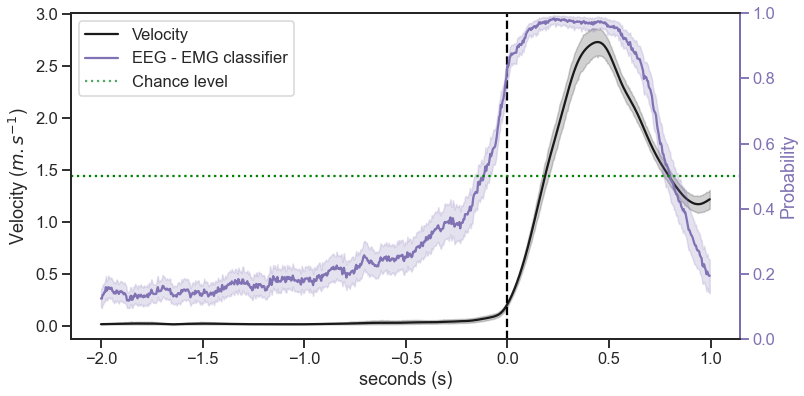

In [36]:
EEG_EMG_6 = ProcessEEG_EMG(6)

Accuracy is 0.6916666666666667
Standard deviation is 0.0696663122443581


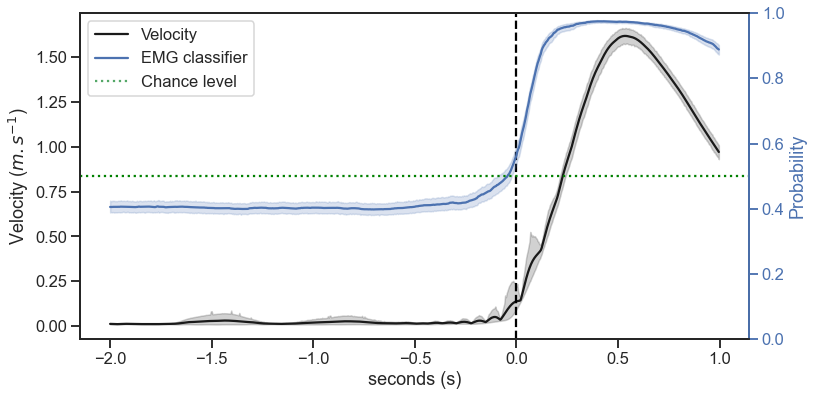

In [37]:
EMG_7 = ProcessEMG(7)

Accuracy is 0.6246825396825397
Standard deviation is 0.07856778089977623


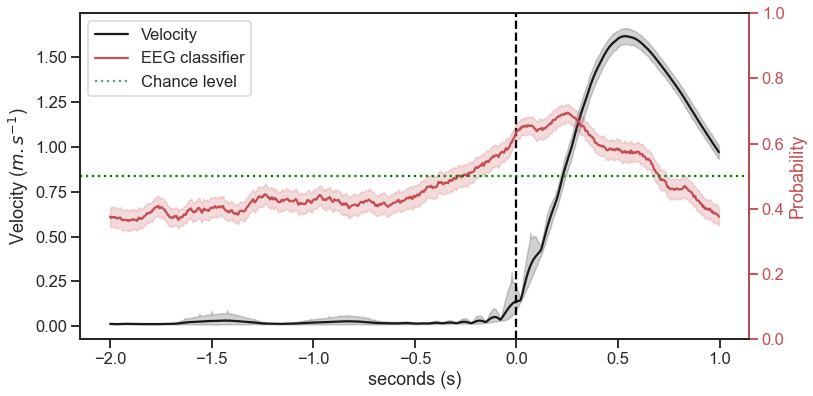

In [38]:
EEG_7 = ProcessEEG(7)

Accuracy is 0.6861111111111111
Standard deviation is 0.07959193767719114


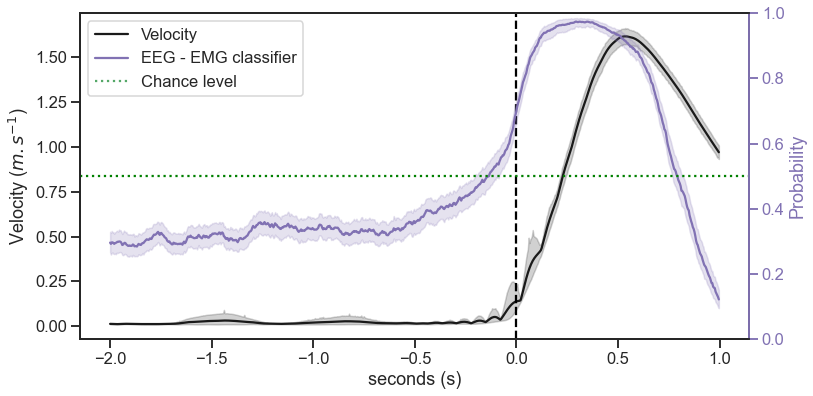

In [39]:
EEG_EMG_7 = ProcessEEG_EMG(7)

In [40]:
EMG = np.concatenate([EMG_1, EMG_3, EMG_4, EMG_5, EMG_6, EMG_7], axis=0)
EMG = pd.DataFrame(EMG, columns=['Time', 'Velocity', 'Probability', 'ID'])

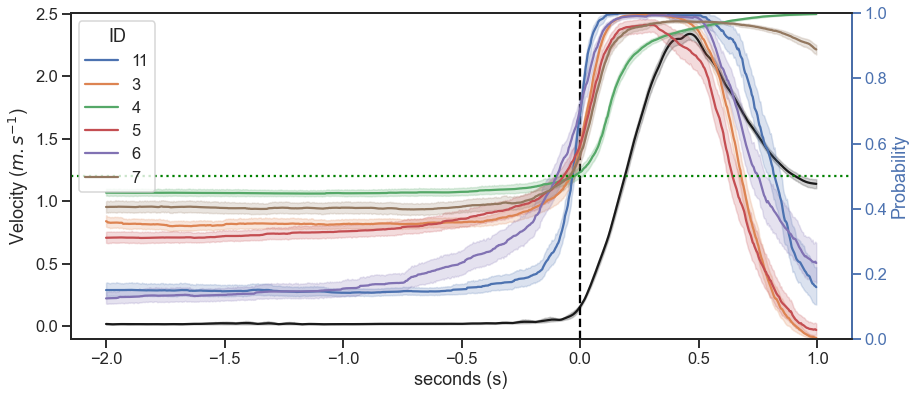

In [41]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=EMG, x='Time', y='Velocity', color='k')

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ep_prob = sns.lineplot(data=EMG, x='Time', y='Probability', hue='ID', ax=ax2)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

#ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
#                                          Line2D([], [], marker='_', color="b", label='EMG classifier'),
#                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

In [42]:
EEG = np.concatenate([EEG_1, EEG_3, EEG_4, EEG_5, EEG_6, EEG_7], axis=0)
EEG = pd.DataFrame(EEG, columns=['Time', 'Velocity', 'Probability', 'ID'])

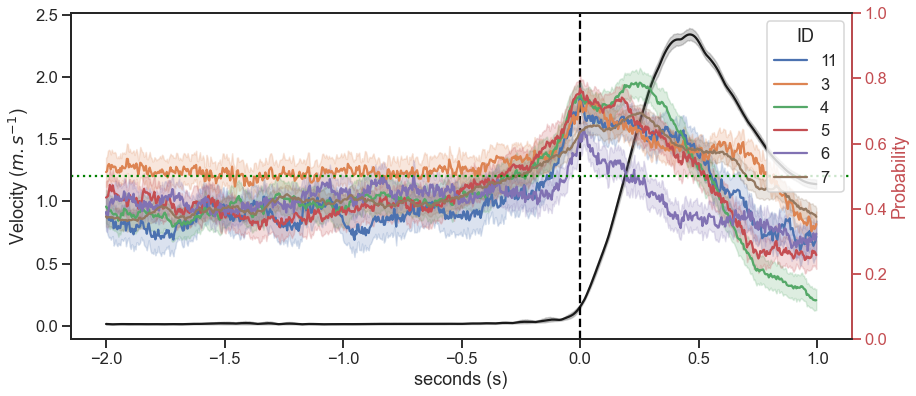

In [43]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=EEG, x='Time', y='Velocity', color='k')

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=EEG, x='Time', y='Probability', hue='ID', ax=ax2)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

#ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
#                                          Line2D([], [], marker='_', color="b", label='EMG classifier'),
#                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

In [44]:
A_EMG = EMG.groupby(['ID', 'Time']).mean()

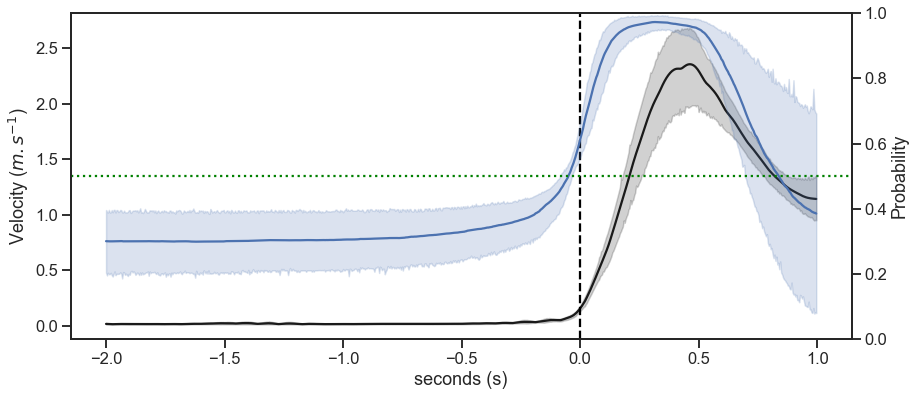

In [45]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=A_EMG, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ax2 = plt.twinx()
#ax2.set_ylabel('Probability', color='r')
#ax2.spines['right'].set_color('r')
#ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=A_EMG, x='Time', y='Probability', ax=ax2)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

#ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
#                                          Line2D([], [], marker='_', color="b", label='EMG classifier'),
#                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

In [46]:
A_EEG = EEG.groupby(['ID', 'Time']).mean()

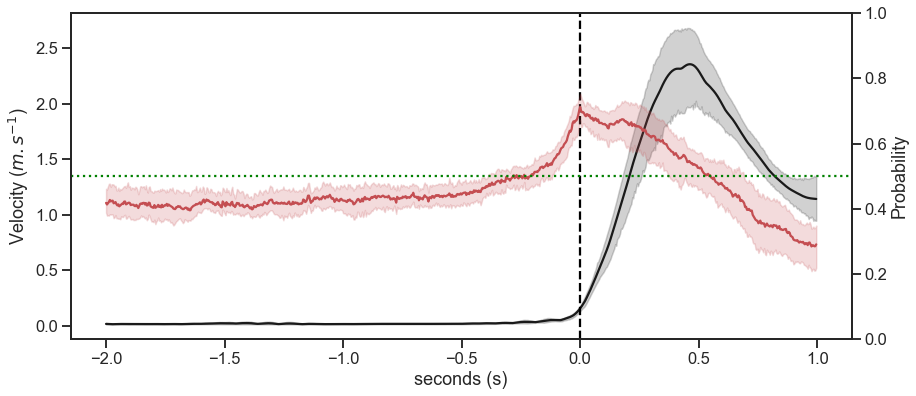

In [47]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=A_EEG, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ax2 = plt.twinx()
#ax2.set_ylabel('Probability', color='r')
#ax2.spines['right'].set_color('r')
#ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=A_EEG, x='Time', y='Probability', color='r', ax=ax2)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

#ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
#                                          Line2D([], [], marker='_', color="b", label='EMG classifier'),
#                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

# II. Accuracy over time

Another way to estimate the classification behaviour over time is to calulate and plot the accurcy on different time periods.
To do so, we use the data above. Instead of training the classifiers on 250 samples (1s) of data, we train them on 50 samples (0.2s) 5 times. That way we get the average accuracy on 5 times periods for each modality.

In [438]:
def accuracy_time(ID):
    
    data = load(ID)
    area = areas(data)
    
    idle_emg_feat = []
    intent_emg_feat = []
    EMG = []
    idle_eeg_feat = []
    intent_eeg_feat =[]
    idle_eeg_feat_cor = []
    intent_eeg_feat_cor =[]
    EEG = []
    idle_eeg_emg_feat = []
    intent_eeg_emg_feat = []
    EEG_EMG = []
    
    
    for i in range(5):
        idle_emg_feat.append(emg_feature_extraction(area['idle_emg'][:, 50*i:50+50*i, :]))
        intent_emg_feat.append(emg_feature_extraction(area['intent_emg'][:, 50*i:50+50*i, :]))
        EMG.append(classification(ID, np.asarray(idle_emg_feat)[i, :, :], np.asarray(intent_emg_feat)[i, :, :]))
        
        idle_eeg_feat.append(eeg_feature_extraction(area['intent_eeg'][:, 50*i:50+50*i, :]))
        intent_eeg_feat.append(eeg_feature_extraction(area['intent_eeg'][:, 50*i:50+50*i, :]))
        idle_eeg_feat_cor.append(baseline_correction(area['idle_eeg'][:, 50*i:50+50*i, :], idle_eeg_feat[i]))
        intent_eeg_feat_cor.append(baseline_correction(area['intent_eeg'][:, 50*i:50+50*i, :], intent_eeg_feat[i]))
        EEG.append(classification(ID, np.asarray(idle_eeg_feat_cor)[i, :, :], np.asarray(intent_eeg_feat_cor)[i, :, :]))
        
        idle_eeg_emg_feat.append(np.concatenate((np.asarray(idle_emg_feat)[i, :, :], 
                                                 np.asarray(idle_eeg_feat)[i, :, :]), axis=1))
        intent_eeg_emg_feat.append(np.concatenate((np.asarray(intent_emg_feat)[i, :, :], 
                                                   np.asarray(intent_eeg_feat_cor)[i, :, :]), axis=1))
        EEG_EMG.append(classification(ID, np.asarray(idle_eeg_emg_feat)[i, :, :], np.asarray(intent_eeg_emg_feat)[i, :, :]))
    
    return EMG, EEG, EEG_EMG

In [439]:
def all_accuracies(IDs):
    
    alla = []
    
    for ID in IDs:
        alla.append(accuracy_time(ID))
    
    accs = []
    ID = []
    mod = ['EMG', 'EEG', 'EEG-EMG']
    moda = []
    tim = ['-900', '-700', '-500', '-300', '-100']
    time = []

    for k in range(len(IDs)):
    
        ID.append([f'{IDs[k]}'] * len(alla[0]) * len(alla[0][0]))
    
        for j in range(len(alla[0])):
        
            moda.append([mod[j]]* len(alla[0][0]))
        
            for i in range(len(alla[0][0])):
        
                accs.append(alla[k][j][i]['Score'])
                time.append(tim[i])
            
    ID = list(np.concatenate(ID).flat)
    moda = list(np.concatenate(moda).flat)

    data = pd.DataFrame(list(zip(accs, time, moda, ID)), columns=['Accuracy', 'Training interval', 'Modality', 'ID'])
    
    figure(figsize=(10,6))
    sns.set_context('talk', rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
    sns.set_color_codes('pastel')
    f= sns.barplot(x = 'Training interval', y='Accuracy', hue = 'Modality', data = data, palette=['tab:blue', 'tab:red', 'tab:purple'])
    f.set(xlabel='Training interval (ms)')
    plt.ylim((0.4,0.9))
    f.legend(loc='upper left')
    sns.despine()
    
    return data

Accuracy is 0.5566666666666666
Standard deviation is 0.07461009761866462
Accuracy is 0.7
Standard deviation is 0.08164965809277262
Accuracy is 0.6533333333333333
Standard deviation is 0.059999999999999984
Accuracy is 0.5233333333333332
Standard deviation is 0.08569973421454961
Accuracy is 0.68
Standard deviation is 0.0653197264742181
Accuracy is 0.6666666666666666
Standard deviation is 0.0760116950066092
Accuracy is 0.5833333333333333
Standard deviation is 0.06708203932499368
Accuracy is 0.6799999999999999
Standard deviation is 0.09910712498212337
Accuracy is 0.6466666666666666
Standard deviation is 0.08326663997864531
Accuracy is 0.61
Standard deviation is 0.07895146188218007
Accuracy is 0.7
Standard deviation is 0.0632455532033676
Accuracy is 0.6433333333333333
Standard deviation is 0.09893881386437221
Accuracy is 0.8566666666666667
Standard deviation is 0.08439325934114775
Accuracy is 0.6433333333333333
Standard deviation is 0.06999999999999999
Accuracy is 0.86
Standard deviation is

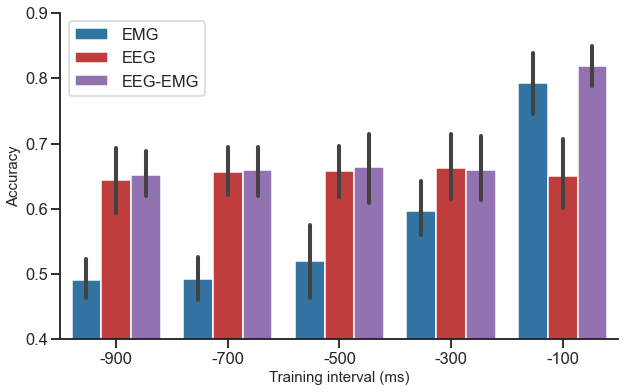

In [440]:
z = all_accuracies([11, 3, 4, 5, 6, 7])

In [441]:
z

,Accuracy,Training interval,Modality,ID
0,0.556667,-900,EMG,11
1,0.523333,-700,EMG,11
2,0.583333,-500,EMG,11
3,0.610000,-300,EMG,11
4,0.856667,-100,EMG,11
...,...,...,...,...
85,0.636111,-900,EEG-EMG,7
86,0.669444,-700,EEG-EMG,7
87,0.700000,-500,EEG-EMG,7
88,0.613889,-300,EEG-EMG,7
